# 2 - Feature Engineering And Preprocessing

Goals:
- Perform light cleaning via sorting, forward fill, backward fill, and mild clipping.
- Generate A-group lag, rolling, and interaction features plus optional B-group ideas.
- Drop residual missing values and persist the curated feature table.
- Visualize how engineered fields track the original signals.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

def configure_style():
    preferred = "seaborn-v0_8-whitegrid"
    fallback = "seaborn-whitegrid"
    candidate = preferred if preferred in plt.style.available else (
        fallback if fallback in plt.style.available else "ggplot"
    )
    plt.style.use(candidate)
    sns.set_context("talk", font_scale=0.8)

configure_style()

In [2]:
def locate_root():
    here = Path.cwd()
    if (here / "data").exists():
        return here
    if (here.parent / "data").exists():
        return here.parent
    return here

project_root = locate_root()
raw_dir = project_root / "data" / "raw" / "3W"
csv_list = sorted(raw_dir.rglob("*.csv"))
if not csv_list:
    raise FileNotFoundError("No CSV files located under data/raw/3W.")
source_path = csv_list[0]

raw = pd.read_csv(source_path)
rename_map = {
    "P-PDG": "pdg", "P-MON-CKP": "pck", "P-JUS-CKGL": "glck", 
    "T-TPT": "tpt", "QGL": "glf",
}
apply_map = {k: v for k, v in rename_map.items() if k in raw.columns}
base = raw.rename(columns=apply_map)

if "timestamp" in base.columns:
    base["timestamp"] = pd.to_datetime(base["timestamp"])
    base = base.set_index("timestamp")

base = base.sort_index()
drop_cols = [c for c in ["", "Unnamed: 0"] if c in base.columns]
if drop_cols:
    base = base.drop(columns=drop_cols)

ordered = [c for c in ["pdg", "pck", "glck", "tpt", "glf"] if c in base.columns]
if not ordered:
    raise ValueError("Expected sensor columns are missing in the source file.")
signals = base[ordered].copy()

print(f"Starting from {source_path.name} with columns: {ordered}")

Starting from WELL-00001_20170201020207.csv with columns: ['pdg', 'pck', 'glck', 'tpt', 'glf']


In [4]:
# Remove faulty sensors
dead_sensors = ["pdg", "glf"]
signals = signals.drop(columns=[col for col in dead_sensors if col in signals.columns], errors='ignore')
print(f"Dropped faulty sensors: {dead_sensors}. Active columns: {signals.columns.tolist()}")

signals = signals[~signals.index.duplicated(keep="first")]
signals = signals.sort_index()
signals = signals.ffill().bfill()
print(signals.describe().T[["mean", "std", "min", "max"]])

clean = signals.copy()
clip_summary = {}
# Outliers were clipped using the 1st and 99th percentiles
for col in clean.columns:
    low, high = clean[col].quantile([0.01, 0.99])
    clean[col] = clean[col].clip(low, high)
    clip_summary[col] = {"low": float(low), "high": float(high)}
print(clip_summary)

Dropped faulty sensors: ['pdg', 'glf']. Active columns: ['pck', 'glck', 'tpt']
              mean            std           min           max
pck   1.579691e+06  178385.792674  9.960668e+05  2.240969e+06
glck  1.565949e+06    1040.053974  1.564147e+06  1.567750e+06
tpt   1.190328e+02       0.036517  1.189421e+02  1.190983e+02
{'pck': {'low': 1152023.27, 'high': 1994321.55}, 'glck': {'low': 1564183.0, 'high': 1567714.0}, 'tpt': {'low': 118.966746, 'high': 119.0977}}


In [5]:
features = clean.copy()
window_short = 5
window_long = 30
window_xlong = 120 


# PCK Features (Volatility, Higher Moments, and Velocity)
if "pck" in clean.columns:
    features["pck_lag1"] = clean["pck"].shift(1)
    features["pck_rm30"] = clean["pck"].rolling(window=window_long, min_periods=window_short).mean()
    features["pck_rsd30"] = clean["pck"].rolling(window=window_long, min_periods=window_short).std()
    features["pck_rskew30"] = clean["pck"].rolling(window=window_long, min_periods=window_short).skew()
    features["pck_rkurt30"] = clean["pck"].rolling(window=window_long, min_periods=window_short).kurt()
    features["pck_slope3"] = clean["pck"].diff(periods=3) / 3.0

# GLCK Features (Trend Removal)
if "glck" in clean.columns:
    features["glck_diff1"] = clean["glck"].diff() 
    features["glck_rm5"] = clean["glck"].rolling(window=window_short, min_periods=1).mean()

# C. TPT Features (Termal Gecikme ve Uzun Rolling)
if "tpt" in clean.columns:
    features["tpt_lag5"] = clean["tpt"].shift(5)
    features["tpt_lag10"] = clean["tpt"].shift(10)
    features["tpt_lag20"] = clean["tpt"].shift(20)
    features["tpt_rm120"] = clean["tpt"].rolling(window=window_xlong, min_periods=window_short).mean()

# Interaction Features
if {"pck", "glck"}.issubset(clean.columns):
    features["pck_glck_diff"] = clean["pck"] - clean["glck"]

if {"pck", "tpt"}.issubset(clean.columns):
    features["pck_tpt_diff"] = clean["pck"] - clean["tpt"]

In [6]:
processed_dir = project_root / "data" / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

# SAFE DROPNA: Instead of dropping rows with any NaNs from rolling/shift features, 
# keep rows where at least 90% of columns are non-NaN.
required_non_nan = int(features.shape[1] * 0.90) 
features_clean = features.dropna(thresh=required_non_nan).copy() 

output_path = processed_dir / "features_clean.csv"
features_clean.to_csv(output_path, index=True)
print(f"Saved {len(features_clean)} rows to {output_path}")

Saved 17869 rows to C:\Users\nisan\Well_Data_Analytics_Project\Well_Data_Analytics_Project\data\processed\features_clean.csv


In [8]:
# Set date format for x-axis in plots
date_form = DateFormatter("%m-%d %H")

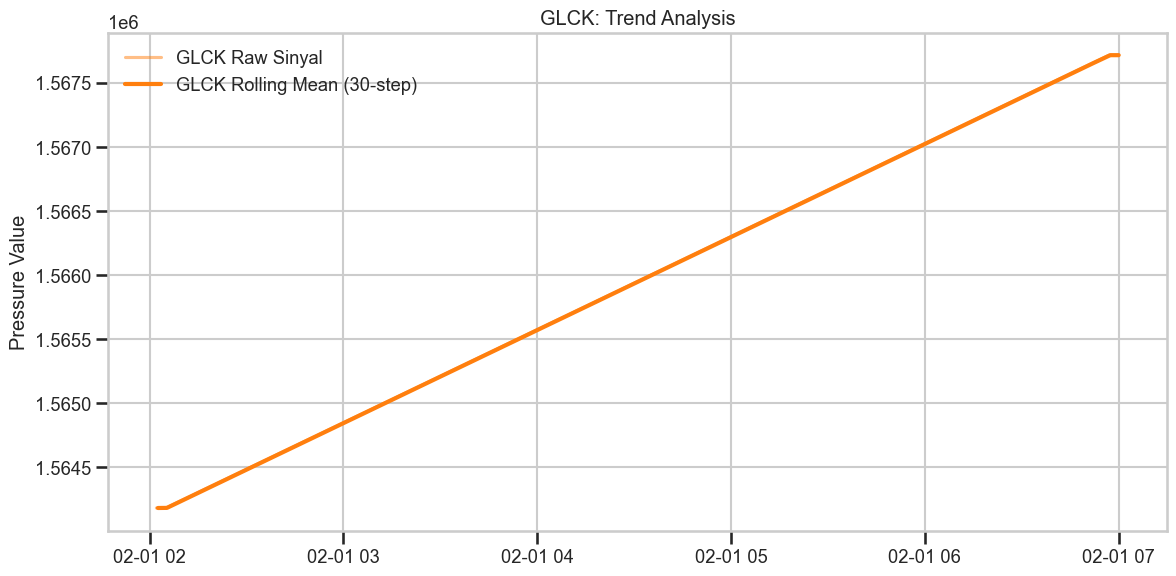

In [10]:
## GLCK Trend Analysis (Validation)
plt.figure(figsize=(12, 6))
if "glck" in clean.columns:
    # Plot raw GLCK signal and rolling mean
    plt.plot(clean.index, clean["glck"], label="GLCK Raw Sinyal", color="#ff7f0e", alpha=0.5)
    plt.plot(clean.index, clean["glck"].rolling(window=30).mean(), label="GLCK Rolling Mean (30-step)", color="#ff7f0e", linewidth=3)
    
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.title("GLCK: Trend Analysis")
    plt.ylabel("Pressure Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

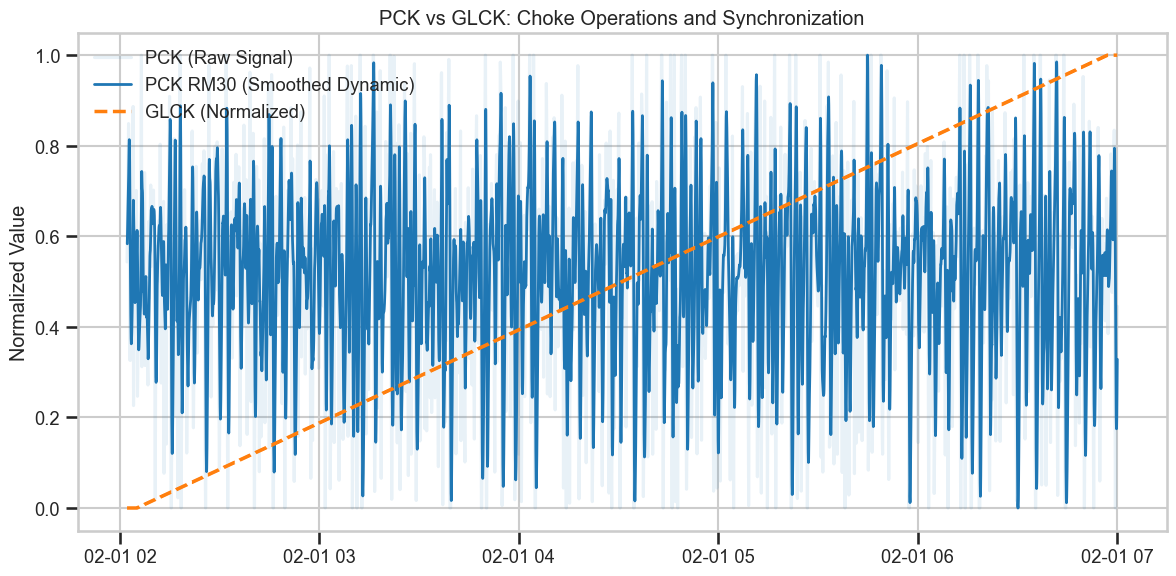

In [11]:
## PCK vs GLCK (Normalized Overlay)
plt.figure(figsize=(12, 6))
if "pck" in clean.columns and "glck" in clean.columns:
    # Normalize pressures on the same scale to show relative changes (Choke Operations)
    pck_scaled = (clean["pck"] - clean["pck"].min()) / (clean["pck"].max() - clean["pck"].min())
    glck_scaled = (clean["glck"] - clean["glck"].min()) / (clean["glck"].max() - clean["glck"].min())
    
    # 30-step rolling mean of PCK to reduce visual noise
    pck_rm30_scaled = (features["pck_rm30"] - features["pck_rm30"].min()) / (features["pck_rm30"].max() - features["pck_rm30"].min())
    
    # De-emphasize raw PCK noise, highlight rolling mean
    plt.plot(clean.index, pck_scaled, label="PCK (Raw Signal)", color="#1f77b4", alpha=0.1)
    plt.plot(clean.index, pck_rm30_scaled, label="PCK RM30 (Smoothed Dynamic)", color="#1f77b4", linewidth=2)
    plt.plot(clean.index, glck_scaled, label="GLCK (Normalized)", color="#ff7f0e", linestyle='--', linewidth=2.5)
        
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.title("PCK vs GLCK: Choke Operations and Synchronization")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

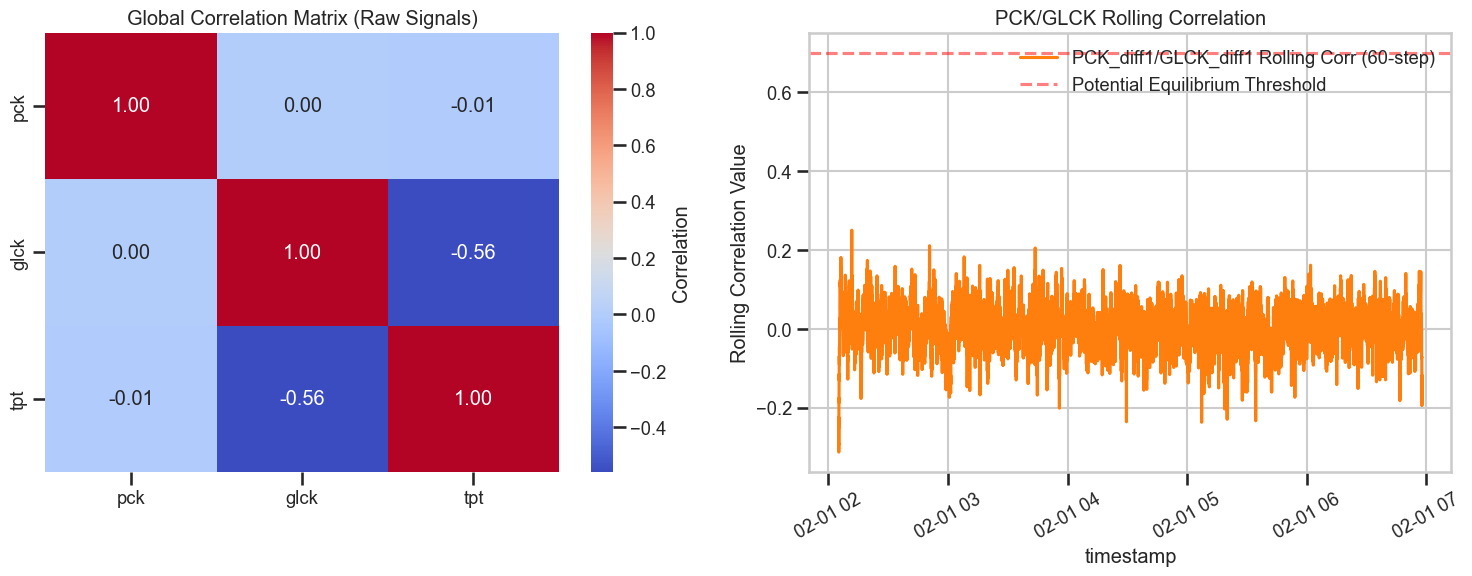

In [14]:
## Correlation Map
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Static and Dynamic
sensor_corr_frame = clean[["pck", "glck", "tpt"]]
corr_matrix = sensor_corr_frame.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title("Global Correlation Matrix (Raw Signals)")

# Dynamic Correlation (Rolling Correlation - Velocity Based)
if "pck" in clean.columns and "glck" in clean.columns:
    # Calculate correlation of first differences (removes trend)
    pck_diff1 = clean["pck"].diff()
    glck_diff1 = clean["glck"].diff()
    rolling_corr_diff = pck_diff1.rolling(window=60).corr(glck_diff1)
    
    axes[1].plot(rolling_corr_diff.index, rolling_corr_diff, label="PCK_diff1/GLCK_diff1 Rolling Corr (60-step)", color="#ff7f0e")
    axes[1].axhline(0.7, color='r', linestyle='--', alpha=0.5, label="Potential Equilibrium Threshold")
    axes[1].set_title("PCK/GLCK Rolling Correlation")
    axes[1].set_ylabel("Rolling Correlation Value")
    axes[1].legend()
    axes[1].set_xlabel("timestamp")
    axes[1].tick_params(axis='x', rotation=30)
    axes[1].xaxis.set_major_formatter(date_form)
plt.tight_layout()
plt.show()

In [15]:
print(features_clean.head())

                           pck       glck       tpt   pck_lag1   pck_rm30  \
timestamp                                                                   
2017-02-01 02:02:12  1651830.0  1564183.0  119.0944  1643424.0  1630815.0   
2017-02-01 02:02:13  1660236.0  1564183.0  119.0945  1651830.0  1635018.0   
2017-02-01 02:02:14  1668642.0  1564183.0  119.0945  1660236.0  1639221.0   
2017-02-01 02:02:15  1677048.0  1564183.0  119.0945  1668642.0  1643424.0   
2017-02-01 02:02:16  1685454.0  1564183.0  119.0945  1677048.0  1647627.0   

                        pck_rsd30   pck_rskew30  pck_rkurt30  pck_slope3  \
timestamp                                                                  
2017-02-01 02:02:12  15726.185997 -9.857843e-11         -1.2      8406.0   
2017-02-01 02:02:13  18159.035437  7.855774e-11         -1.2      8406.0   
2017-02-01 02:02:14  20590.410778  2.269233e-12         -1.2      8406.0   
2017-02-01 02:02:15  23020.779092  0.000000e+00         -1.2      8406.0   
2017

`features_clean.head()` confirms column order and naming; quick inspection also shows that ratio and z-score columns stay finite, meaning our NaN drop removed any problematic rows.
